In [1]:
import pandas as pd
import sys
import math
import numpy as np

from matplotlib import pyplot as plt

sys.path.append('../utils')
from Album import *
from Concert import *
from Artist import *
from NumpyEncoder import * 
from utils import *

%load_ext autoreload
%autoreload 2


# Cleaning the collected data from different sources to form one unique Json file

## Clean Album dataset

In [2]:
def treat_json_file(in_path2,in_path3,utils,unique_alb,albums,clean_genres,genres) :
   
    albums_json = None
    if in_path2 is not None :
        with open(in_path2,encoding="utf-8") as f:
            albums_json = json.load(f)      
        df_missing_alb = pd.read_csv(in_path3,sep=',')
    
   
    ranks = df_missing_alb['rank']
    ratings = df_missing_alb['rating']
    years = df_missing_alb['year'] 
    i = 0
  
    for tuple in albums_json:
        result = utils.get_albums_info_from_json(tuple)
     
        if result == None :
            continue
        
        albums_id,album_title,artists,label = result
        if albums_id in unique_alb :
            i += 1
            continue
        else :   
            unique_alb.add(albums_id) 
      
        year = None
        if(str(years[i]) not in 'nan') :   
            year = str(years[i]).split(" ")
            if len(year) == 2 :
                year = year[1]
            elif len(year) == 3: 
                year = year[2]
            else :
                year = year[0]       

        final_genres = set()    
        for g in genres[ranks[i]-1]: 
            for cg in clean_genres['name'] :
                if g in cg : 
                    final_genres.add(g)    
        if len(final_genres) == 0 :
            final_genres.add(clean_genres['name'][0])    
        album = Album(albums_id,album_title,artists,year,label,ranks[i],ratings[i],list(final_genres))
        albums.append(album.to_dict())
        i += 1
       
    return albums


In [4]:
def check_musician_role(role) :
    musician_role = pd.read_csv("../../data/roles/musician_role_only.csv",sep=',') 
    clean_role = list()
    for r in role.split(",") :
            if r in musician_role['role']: 
                 clean_role.append(r)

    return clean_role              

In [3]:
def clean_data(charts,clean_genres,in_path1,in_path2=None,in_path3=None,out_path=None) : 

    df = pd.read_csv(in_path1,sep=',')    
    genres = pd.read_csv(charts,sep=";")
    genres = genres['Genres'].apply(lambda x: x.split(",")) 
    genres = genres.apply(lambda x: [j.lower().strip() for j in x ]) 


    alb_title = df['title']
    alb_id = df['album_id']
    art_id = df['artist_id']
    art_name = df['artist_name']
    roles = df['role']
    ratings = df['rating']
    ranks = df['rank']
    years = df['year'] 
    labels = df['label']
    extra = df['extra']
    utils = Utils()

    artists = list()
    albums = list() 
    unique_alb = set()
    current_alb = alb_id[0]

    #Csv file
    for i in range(0,len(alb_id)):

        if current_alb != alb_id[i] : 
            if current_alb in unique_alb :
               current_alb = alb_id[i]
               artists = list()
               continue
            else :   
                unique_alb.add(current_alb) 

            final_genres = set()    
            for g in genres[ranks[i-1]-1] : 
                for cg in clean_genres['name'] :
                    if g in cg : 
                        final_genres.add(g)
            
            if len(final_genres) == 0 :
                final_genres.add(clean_genres['name'][0])  


            album = Album(alb_id[i-1],alb_title[i-1],artists,years[i-1] if len(str(years[i-1]))> 0 else None ,labels[i-1].split(','),ranks[i-1],ratings[i-1], list(final_genres))
            albums.append(album.to_dict())
            current_alb = alb_id[i]
            artists = list()
        
        roles = check_musician_role(str(roles[i]))
        
        clean_roles = utils.clean_role(roles,True)    
        if str(0) in str(extra[i]) :
           clean_roles.append("main artist")  
        if len(clean_roles) != 0 :    
            clean_art_name = utils.clean_artist_name(art_name[i])
            artist = Artist(art_id[i],clean_art_name,clean_roles)
            artists.append(artist.to_dict())
        
    # json file 
    
    if in_path2 is not None :
       albums  = treat_json_file(in_path2,in_path3,utils,unique_alb,albums,clean_genres,genres)

    with open(out_path,"w",encoding='utf-8') as write_file:
            json.dump(albums, write_file, indent=4,cls=NumpyEncoder)     
   

### Jazz album dataset 

In [14]:
clean_genres = pd.read_csv("../../data/genres/clean_genres.csv",sep=",")
clean_genres['name'] = clean_genres['name'].apply(lambda x: x.lower()) 

clean_data('../../data/albums_chart/rym_charts.csv',clean_genres,'../../data/albums/jazz/albums_top5000-final.csv','../../data/albums/jazz/missing_albums_details.json'
           ,'../../data/albums/jazz/missing_albums_ratings.csv','../../data/albums/jazz/album-final.json')

### Classical music dataset

In [25]:
#charts,clean_genres,in_path1,in_path2=None,in_path3=None,out_path=None
clean_genres = pd.read_csv("../../data/genres/classical_genres.csv",sep=",")
clean_genres['name'] = clean_genres['name'].apply(lambda x: x.lower()) 
clean_data("../../data/albums_chart/rym_chart_classical.csv",clean_genres,'../../data/albums/classical/albums_top5000_classical.csv'
           ,'../../data/albums/classical/missing_classical_albums_details.json','../../data/albums/classical/missing_classical_albums_ratings.csv','../../data/albums/classical/album-final-classical.json')

### Hip Hop dataset

In [36]:
clean_genres = pd.read_csv("../../data/genres/hip_hop_genre.csv",sep=",")
clean_genres['name'] = clean_genres['name'].apply(lambda x: x.lower()) 
clean_data("../../data/albums_chart/rym_chart_hip_hop.csv",clean_genres,'../../data/albums/hip_hop/albums_top5000_hip_hop.csv'
           ,'../../data/albums/hip_hop/missing_hip_hop_albums_details.json','../../data/albums/hip_hop/missing_hip_hop_albums_ratings.csv','../../data/albums/hip_hop/album-final-hip_hop.json')

## Clean MJF dataset

In [152]:
def clean_data_mjf(in_path) : 

    albums_json = None
    with open(in_path,encoding="utf-8") as f:
            albums_json = json.load(f)  
               
    categories_json = None
    with open('../../data/genres/genres_cat.json',encoding="utf-8") as f:
            categories_json = json.load(f)  

    concerts = list() 
    utils = Utils()
    idx = 0
    for tuple in albums_json:
      
        result = utils.get_concert_info_from_json(tuple)
        concert_id,concert_name,artists,concert_date,concert_location,concert_genres = result
        concert_cat = set()
        for g in concert_genres :
            for cat in categories_json["categories"] :   
                  for cat_g in cat['genres'] :       
                    if g.lower() == cat_g.lower() : 
                       concert_cat.add(cat['category'])
       
        concert = Concert(id=concert_id,name=concert_name,artists=artists,date=concert_date,location=concert_location,genres=concert_genres,categories=list(concert_cat))
       
        concerts.append(concert.to_dict())

        if idx == 500 :
            print(idx) 
            idx = 0
        idx+=1    
    with open("../../data/mjf/mfj_export_clean-final.json","w",encoding='utf-8') as write_file:
        json.dump(concerts, write_file, indent=4,cls=NumpyEncoder)  


In [155]:
clean_data_mjf("../../data/mjf/mfj_export_clean.json")

500
500
500
500
500
500
500
500
500


# General informations on dataset

# Album dataset 

In [32]:
def get_dataset_info(filename) :
    albums_json = None
    with open(filename,encoding="utf-8") as f:
            albums_json = json.load(f)    
    unique_artist = set()
    genres = 0
    nb_no_art = 0
    nb_no_role = 0
    nb_no_label = 0
    nb_no_year = 0
    max = -np.inf
    min = np.inf
    for i in albums_json : 
        if len(i['artists']) == 0 :
            nb_no_art+=1
        if (i['genres'] == None) or (len(i['genres']) == 0):
                genres += 1
        if len(i['labels']) == 0 :  
            nb_no_label+=1
        for art in i['artists']:
            if art['role'][0] == "" or  art['role'][0] == "nan" or  len(art['role']) ==0 :
                
                nb_no_role+=1
            if art['id'] not in unique_artist:
                unique_artist.add(art['id'])
           
        if i['year'] != None :
            year = i['year']
            if max < int(year) :
                max = int(year)
            if min > int(year) :
                min = int(year)
        else :
            nb_no_year += 1         
    print("Nb albums:",len(albums_json))            
    print("Nb artists:",len(unique_artist))
    print("Min date:",min)
    print("Max date:",max)        
    print("-------Completeness--------")
    print("Nb no genre:",genres)      
    print("Nb no artist:",nb_no_art)       
    print("Nb no role:",nb_no_role)      
    print("Nb no label:",nb_no_label)  
    print("Nb no year:",nb_no_year)  

### Jazz album dataset 

In [21]:
get_dataset_info("../../data/albums/jazz/album-final.json")

Nb albums: 4741
Nb artists: 23235
Min date: 1939
Max date: 2023
-------Completeness--------
Nb no genre: 0
Nb no artist: 0
Nb no role: 0
Nb no label: 0
Nb no year: 0


### Classic music Album dataset

In [34]:
get_dataset_info("../../data/albums/classical/album-final-classical.json")

Nb albums: 3668
Nb artists: 25132
Min date: 0
Max date: 2023
-------Completeness--------
Nb no genre: 0
Nb no artist: 0
Nb no role: 0
Nb no label: 0
Nb no year: 0


### Hip Hop Album dataset

In [37]:
get_dataset_info("../../data/albums/hip_hop/album-final-hip_hop.json")

Nb albums: 4351
Nb artists: 16116
Min date: 1980
Max date: 2023
-------Completeness--------
Nb no genre: 0
Nb no artist: 0
Nb no role: 0
Nb no label: 0
Nb no year: 0


### year repartition 

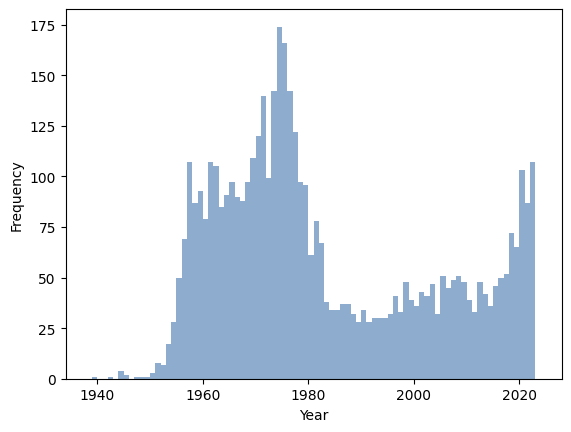

In [49]:

years = list()
for alb in albums_json : 
    if alb['year'] != None :
        years.append(int(alb['year']))


nbins = np.max(years) - np.min(years)

plt.xlim([np.min(years)-5, np.max(years)+5])
plt.hist(years, bins=nbins, alpha=1, color="#8EACCD")
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.savefig("../../data/repartition/album_year_repartition.png",format="png")
plt.show()   

# MJF dataset

In [2]:
mjf_json = None
with open("../../data/mjf/mfj_export_clean-final.json",encoding="utf-8") as f:
            mjf_json = json.load(f)      

### Info dataset

In [3]:
max = -np.inf
min = np.inf
unique_musician = set()
instruments = set()
nb_concerts = 0
nb_no_instrument = 0
nb_no_date = 0
nb_all_musi = 0
nb_no_musician = 0
no_genres = 0 
genres = set()
more_one_genres = 0
for concert in mjf_json :
    
    if len(concert['musicians'] ) == 0 or concert['musicians'][0] == "":  
        nb_no_musician += 1
        continue

    nb_concerts += 1
    nb_all_musi += len(concert['musicians'] )

    if len(concert['genres'] ) > 1 :
        more_one_genres+=1
    if concert['genres'][0] == "" or  len(concert['genres'] ) == 0:
        no_genres+=1
    else : 
      for g in concert['genres']: 
            genres.add(g)    
            
    for art in concert['musicians'] :
        if len(art['role']) == 0 or art['role'][0] == "" : 
            nb_no_instrument += 1 

        for inst in art['role']:
            if inst not in instruments :
                instruments.add(inst)
      
        if art['id'] not in unique_musician :
            unique_musician.add(art['id'])


    if concert['date'] == None or concert['date'] == "":
        nb_no_date +=1
        continue
    year = concert['date'].split("-")[0]
    if max < int(year) :
        max = int(year)
    if min > int(year) :
        min = int(year)

print("Nb musicians:",len(unique_musician) )       
print("Nb concerts:",nb_concerts )     
print("Nb of roles",len(instruments))
print("Nb of genres",len(genres))
print("Nb of more than one genre",more_one_genres)
print("Min date:",min)
print("Max date:",max)
print("------Completeness--------")
print("Nb no musicians:",nb_no_musician)
print("Nb no instrument:",nb_no_instrument)
print("Nb no date:",nb_no_date)
print("Nb no genres:",no_genres)


Nb musicians: 17639
Nb concerts: 4280
Nb of roles 255
Nb of genres 94
Nb of more than one genre 1816
Min date: 1967
Max date: 2023
------Completeness--------
Nb no musicians: 574
Nb no instrument: 2623
Nb no date: 0
Nb no genres: 968


In [4]:
instruments

{'ableton',
 'accordion',
 'acoustic drums',
 'ad',
 'agogo',
 'akai mpc',
 'alphorn',
 'bacurinha',
 'bag pipes',
 'bajo sexto',
 'balafon',
 'bandolin',
 'bandoneon',
 'bandurria',
 'banjo',
 'bansuri',
 'bara',
 'baritone ukulele',
 'bassoon',
 'bata',
 'beats',
 'bell',
 'berimbau',
 'big conga',
 'big drum',
 'biniou',
 'bodhran',
 'body percussion',
 'bombard',
 'bombo',
 'bones',
 'bongo',
 'boobam',
 'bouzouki',
 'brass',
 'büchel',
 'caixinha',
 'cajon',
 'calabash',
 'cavaquinho',
 'cello',
 'charango',
 'cittern',
 'claps',
 'clarinet',
 'clavinet',
 'computer',
 'computer music programmation',
 'concertina',
 'conch',
 'congas',
 'control box',
 'controller',
 'cornet',
 'cowbell',
 'cristal baschet',
 'cuica',
 'cymbal',
 'daf',
 'decks',
 'dhol',
 'didgeridoo',
 'digital sound system',
 'dj',
 'djembe',
 'dobro',
 'double bass',
 'double seconds',
 'double violin',
 'drum',
 'drum machine',
 'drum pad',
 'drumitar',
 'drums',
 'dum dum',
 'dutar',
 'e bow',
 'echoes',
 'e

In [ ]:
from collections import Counter
Counter(genres)

In [50]:
nb_cells = len(mjf_json) * 3  
print(nb_cells)
print((nb_no_musician + nb_no_instrument))
completeness = 1  -  ((nb_no_musician + nb_no_instrument) / nb_cells)
print(completeness)

14562
3197
0.780455981321247


### Concert year repartition

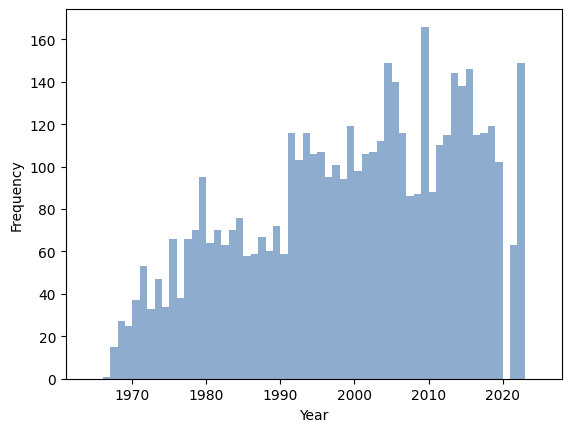

In [50]:

years = list()
for concert in mjf_json['concerts'] : 
    if concert['date']  != None :
        years.append(int(concert['date'].split("-")[0] ))

nbins = np.max(years) - np.min(years)

plt.xlim([np.min(years)-5, np.max(years)+5])
plt.hist(years, bins=nbins, alpha=1,color='#8EACCD')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.savefig("../../data/repartition/mjf_year_repartition.png",format="png")
plt.show()   

In [ ]:
import requests
from bs4 import BeautifulSoup

def get_jazz_genres(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Finding all <td> elements with <a> tags
    li_elements = soup.find_all('li')
    
    # Extracting the text content of each <a> tag
    genres = [li.find('a').text.strip() for li in li_elements if li.find('a', {'title': True},{'href': True})]

    return genres

if __name__ == "__main__":
    wikipedia_url = "https://en.wikipedia.org/wiki/List_of_classical_music_genres"
    jazz_genres = get_jazz_genres(wikipedia_url)

    # Printing the list of jazz genres
    for index, genre in enumerate(jazz_genres, start=1):
        print(genre)

In [64]:
import requests
from bs4 import BeautifulSoup

def get_hip_hop_genres(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Finding the <div> with class "mw-content-ltr mw-parser-output"
    content_div = soup.find('div', class_='mw-content-ltr mw-parser-output')

    # Finding all <li> elements with <a> tags and a "title" attribute
    genre_elements = content_div.find_all('li')  # Exclude elements with 'class' or 'id' attributes

    # Extracting the text content of the "title" attribute of each <a> tag
    genres = [li.find('a').text.strip() for li in genre_elements if li.find('a', {'title': True},{'href': True})]

    return genres

if __name__ == "__main__":
    wikipedia_url = "https://en.wikipedia.org/wiki/List_of_hip_hop_genres"
    hip_hop_genres = get_hip_hop_genres(wikipedia_url)

    # Printing the list of hip-hop genres
    for index, genre in enumerate(hip_hop_genres, start=1):
        print(genre)

Roots of hip hop
Old school hip hop
New school hip hop
Golden age hip hop
Alternative hip hop
Experimental hip hop
Hipster hop
Boom bap
Bounce
British hip hop
Road rap
Chopped and screwed
Chopper
Christian hip hop
Cloud rap
Comedy hip hop
Crunk
Crunkcore
East Coast hip hop
Freestyle rap
Funk carioca
Funk ostentação
G-funk
Hardcore hip hop
Dirty rap
Gangsta rap
Mafioso rap
Horrorcore
Memphis rap
Hyphy
Jerkin'
Instrumental hip hop
Latin hip hop
Chicano rap
Lofi hip hop
Miami bass
Mumble rap
Nerdcore
Chap hop
Political hip hop
Conscious hip hop
Progressive rap
Christian hip hop
Christian hip hop
Jewish hip hop
Snap music
Southern hip hop
Trap music
Drill music
Brooklyn drill
UK drill
Latin trap
Phonk
Plugg
Rage rap
Tread rap
Turntablism
Underground hip hop
West Coast hip hop
Country rap
Electro
Emo rap
Hip hop soul
Hip house
Industrial hip hop
Jazz rap
New jack swing
Pop rap
Punk rap
Ragga hip hop
Rap opera
Rap rock
Rap metal
Trap metal
Rapcore
Trip hop
Breakbeat
Baltimore club
Florida br

### Evolution of the Genres by year

In [3]:
normalized_dict = pd.json_normalize(mjf_json, sep=',')
normalized_dict = normalized_dict.explode('categories')

In [4]:
normalized_dict['date'] = normalized_dict['date'].apply(lambda x : x.split('-')[0])
genres_rep = normalized_dict.groupby(by=['date','categories']).count().unstack(fill_value=0).stack().iloc[:,0:1]
genres_rep['total'] = genres_rep['id'].div(genres_rep.groupby(['date'])['id'].transform('sum')) 
genres_rep = genres_rep.reset_index()

In [5]:
normalized_dict_p1 = genres_rep[(genres_rep['categories'] != "Electronic/Dance")& (genres_rep['categories'] != "Hip-Hop/Rap") & (genres_rep['categories']) 
                                     &(genres_rep['categories'] != "Folk") & (genres_rep['categories'] != "Other") & (genres_rep['categories'] != "Classical/Contemporary")& 
                                    (genres_rep['categories'] != "Pop")]

normalized_dict_p2 = genres_rep[(genres_rep['categories'] == "Electronic/Dance") |  (genres_rep['categories'] == "Hip-Hop/Rap") 
                                     &(genres_rep['categories'] == "Folk") |  (genres_rep['categories'] == "Other")  | (genres_rep['categories'] == "Classical/Contemporary") | 
                                    (genres_rep['categories'] == "Pop")]                                    

In [12]:
cat = normalized_dict.groupby(by=['categories']).count().iloc[:,0:1]

In [17]:
cat = cat.reset_index()

In [31]:
sub_df = pd.json_normalize(mjf_json, sep=',')

In [45]:
q1 = normalized_dict[(normalized_dict['categories'] == "R&B/Soul & blues") |  (normalized_dict['categories'] == "Rock/Metal") ]
q2 = q1.groupby(by=['id']).count().reset_index()#[(normalized_dict['name'] == 2)]['id']
ids = q2[(q2['name'] == 2)]["id"]
len(ids)


160

In [48]:
df = pd.json_normalize(mjf_json, sep=',')

In [ ]:
for i in range(0,len(df)) :
    for id in ids :
        if(df.iloc[i,:]['id']==id) :
            print(str(id) + str(df.iloc[i,:]['genres'])+ "-------" + str(df.iloc[i,:]['categories']))

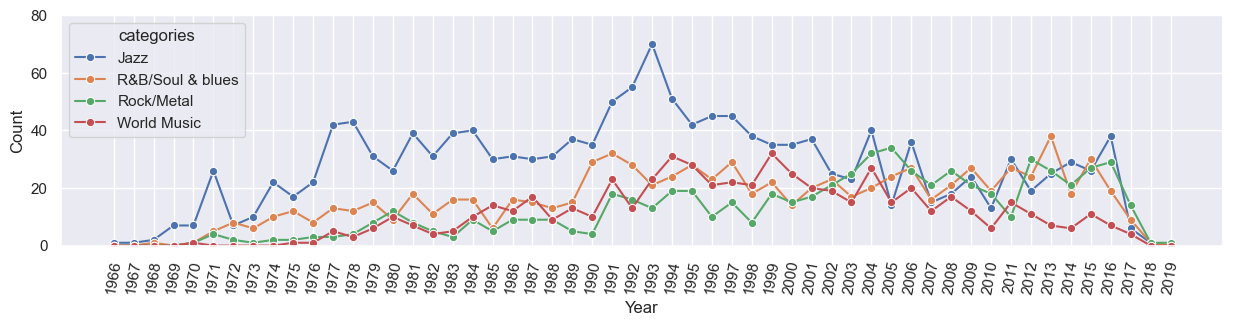

In [6]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,3)})
fig,ax = plt.subplots()
ax.tick_params(axis='x', rotation=80)
ax.set_yticks([0,20,40,60,80])
ax.set(ylim=(-0.2, 80))
ax.set(xlabel='Year', ylabel='Count')
sns.lineplot(
    data=normalized_dict_p1, 
    x='date', y='id', hue='categories', marker='o')
sns.move_legend(ax, "upper left")

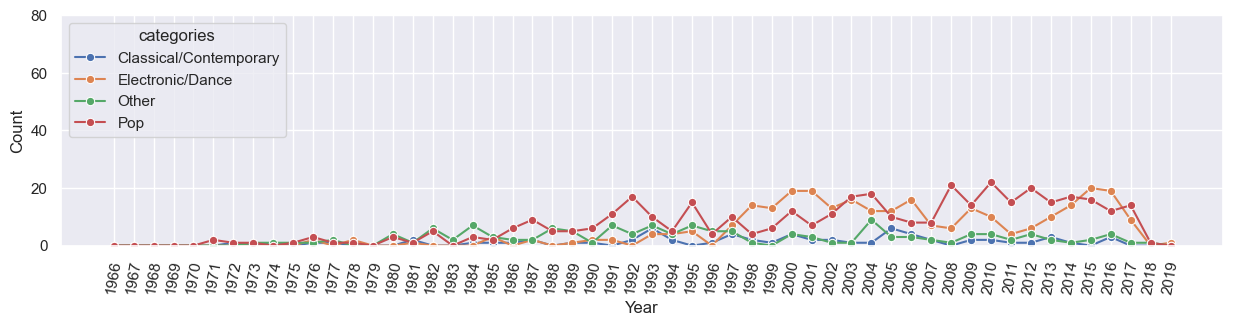

In [7]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,3)})
fig,ax = plt.subplots()
ax.tick_params(axis='x', rotation=80)
ax.set_yticks([0,20,40,60,80])
ax.set(ylim=(-0.2, 80))

ax.set(xlabel='Year', ylabel='Count')
sns.lineplot(
    data=normalized_dict_p2, 
    x='date', y='id', hue='categories', marker='o')
sns.move_legend(ax, "upper left")

### Evolution of the Jazz sub-genres by year

In [20]:
normalized_dict = pd.json_normalize(mjf_json, sep=',')
normalized_dict = normalized_dict.explode('genres')

In [21]:
normalized_dict['date'] = normalized_dict['date'].apply(lambda x : x.split('-')[0])
normalized_dict['genres']  = normalized_dict['genres'].apply(lambda x : "big band" if x=="big band music" else x)
normalized_dict = normalized_dict[(normalized_dict['genres'] == "Afro-Cuban jazz") | (normalized_dict['genres'] == "swing music")  |
                                (normalized_dict['genres'] == "bebop")  | (normalized_dict['genres'] == "Gypsy jazz")  |
                                (normalized_dict['genres'] == "jazz fusion")  | (normalized_dict['genres'] == "boogie-woogie") |
                                (normalized_dict['genres'] == "bossa nova") | (normalized_dict['genres'] == "acid jazz") |
                                (normalized_dict['genres'] == "Latin jazz") | (normalized_dict['genres'] == "crossover jazz") | 
                                (normalized_dict['genres'] == "post-bop") | (normalized_dict['genres'] == "lounge music") |
                                (normalized_dict['genres'] == "hard bop") | (normalized_dict['genres'] == "free jazz") | 
                                (normalized_dict['genres'] == "cool jazz") | (normalized_dict['genres'] == "jazz-funk") | 
                                (normalized_dict['genres'] == "jazz") | (normalized_dict['genres'] == "Dixieland jazz")  | (normalized_dict['genres'] == "big band")  ]

genres_rep = normalized_dict.groupby(by=['date','genres']).count().unstack(fill_value=0).stack().iloc[:,0:1]

genres_rep['total'] = genres_rep['id'].div(genres_rep.groupby(['date'])['id'].transform('sum')) 
genres_rep = genres_rep.reset_index()

In [22]:
"""
genres_rep = genres_rep[(genres_rep['genres'] == "Afro-Cuban jazz")  |
                                (genres_rep['genres'] == "bebop")  | (genres_rep['genres'] == "Gypsy jazz")  |
                                (genres_rep['genres'] == "lounge music")  | (genres_rep['genres'] == "boogie-woogie") |
                                (genres_rep['genres'] == "bossa nova") | (genres_rep['genres'] == "acid jazz") |
                                (genres_rep['genres'] == "Latin jazz") | (genres_rep['genres'] == "crossover jazz") 
                                 ]
"""  

genres_rep = genres_rep[ (genres_rep['genres'] == "swing music")   |
                         
                                (genres_rep['genres'] == "post-bop") | (genres_rep['genres'] == "jazz fusion") |
                                (genres_rep['genres'] == "hard bop") | (genres_rep['genres'] == "free jazz") | 
                                (genres_rep['genres'] == "cool jazz") | (genres_rep['genres'] == "jazz-funk") | 
                                (genres_rep['genres'] == "jazz") | (genres_rep['genres'] == "Dixieland jazz") |  (genres_rep['genres'] == "big band") ]


In [23]:
genres_rep['genres'] =  genres_rep['genres'].apply(lambda x :  "uncategorized jazz" if x =='jazz' else x)
genres_rep['genres'] =  genres_rep['genres'].apply(lambda x :  "dixieland jazz" if x =='Dixieland jazz' else x)

In [117]:
genres_rep['genres'] =  genres_rep['genres'].apply(lambda x :  "afro-Cuban jazz" if x =='Afro-Cuban jazz' else x)
genres_rep['genres'] =  genres_rep['genres'].apply(lambda x :  "gypsy jazz" if x =='Gypsy jazz' else x)
genres_rep['genres'] =  genres_rep['genres'].apply(lambda x :  "latin jazz" if x =='Latin jazz' else x)

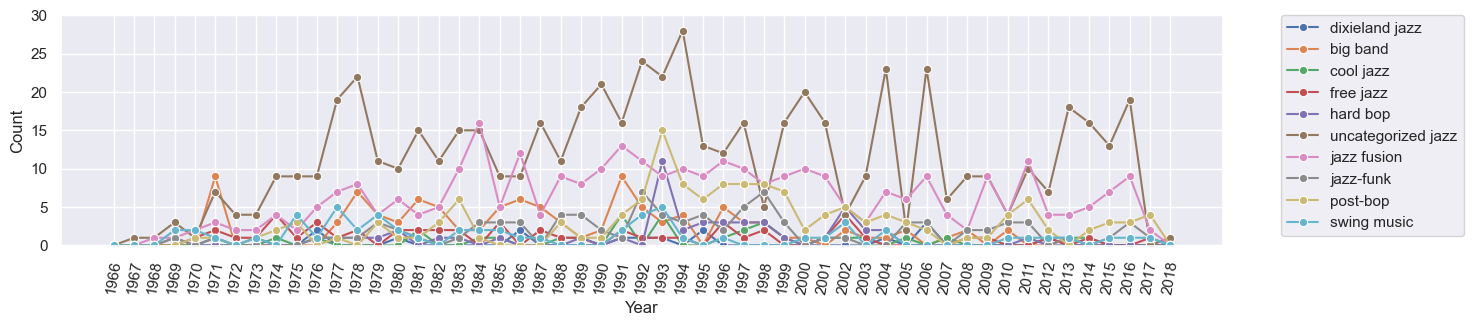

In [25]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,3)})
fig,ax = plt.subplots()
ax.tick_params(axis='x', rotation=80)
#ax.set_yticks([0,0.5,1])
#ax.set(ylim=(-0.1,1.1))
ax.set_yticks([0,5,10,15,20,25,30])
ax.set(ylim=(-0.1,30))
ax.set(xlabel='Year', ylabel='Count')
sns.lineplot(
    data=genres_rep, 
    x='date', y='id', hue='genres', marker='o')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Genres per artists  

In [131]:
import csv

In [66]:
cat = None
with open("../../data/genres/genres_cat.json",encoding="utf-8") as f:
            cat = json.load(f)  
normalized_dict = pd.json_normalize(cat['categories'], sep=',')
jazz_subgenres = list(normalized_dict[(normalized_dict['category']=='Jazz')]['genres'])[0]

In [30]:
import csv
musicians = dict()
for concert in mjf_json :
    genres = concert['genres']     
    if  len(genres) == 0 or genres[0] == "":
        continue    

    for art in concert['musicians'] :
        if art['id'] not in musicians.keys() :
                musicians[art['id']] = set()
        for g in genres:
            for g2 in jazz_subgenres : 
                if g.lower() == g2.lower() :
                    musicians[art['id']].add(g.lower())


In [31]:
             
with open('../../data/genres/musician_jazz_sub_genre.csv', 'w',encoding="utf-8") as f:
    [f.write('{0};{1}\n'.format(key,','.join(list(value)))) for key, value in musicians.items()]

### Retrieve musicians informations

In [3]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

In [4]:
endpoint_url = "https://query.wikidata.org/sparql"
def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

In [12]:
def get_artist(musician_id): 
  query ="""SELECT  ?wd_item_label  ?wd_gender_label (group_concat(DISTINCT ?wd_country_label;separator=";") as ?wd_country_labels) 
        (group_concat(DISTINCT ?mjf_birth_place_label;separator=";") as ?mjf_birth_place_labels) 
        (group_concat(DISTINCT ?mjf_genre_label;separator=";") as ?mjf_genre_labels) 
        WHERE {
          { ?concert_mjf wdt:P8301 ?wd_item } .
          OPTIONAL {?concert_mjf wdt:P21   ?mjf_gender} . 
          OPTIONAL {?concert_mjf wdt:P27   ?mjf_country }  . 
          OPTIONAL {?concert_mjf wdt:P19   ?mjf_birth_place }  . 
          OPTIONAL {?concert_mjf wdt:P136  ?mjf_genre}  . 
          SERVICE wikibase:label { bd:serviceParam wikibase:language "en". 
                                  ?wd_item rdfs:label ?wd_item_label . 
                                  ?mjf_gender rdfs:label ?wd_gender_label . 
                                  ?mjf_country  rdfs:label ?wd_country_label .
                                  ?mjf_birth_place  rdfs:label ?mjf_birth_place_label .
                                  ?mjf_genre  rdfs:label ?mjf_genre_label                               
          }
          FILTER(?wd_item = """ + "\"" + str(musician_id) + "\"" + """)   
          bind(COALESCE( ?wd_country_label,"NaN") as ?wd_country_label)
          bind(COALESCE( ?wd_gender_label,"NaN") as ?wd_gender_label)
        }
        GROUP BY ?wd_item_label ?wd_gender_label """
  try :
     results_artist = get_results(endpoint_url, query)
     results_artist  = results_artist["results"]["bindings"]
  except Exception as e:
      return None

  if len(results_artist) == 0:
    return None
  
  for r in results_artist :
    return  (r["wd_item_label"]["value"],r["wd_gender_label"]["value"],r["wd_country_labels"]["value"],
             r["mjf_birth_place_labels"]["value"] ,
             r["mjf_genre_labels"]["value"] )

In [9]:
df = pd.read_csv("../../data/genres/musician_id.csv",sep=';')
df.head()

,name,id
0,jenna davis,30407
1,rhythm queen,9124
2,angela wynter,30423
3,christine,30421
4,jenny,30420


In [16]:
with open('../../data/artists/mjf_musicians_info.csv', 'w', encoding='utf-8') as f:
    for id in df['id']:   
        csv_line = get_artist(id)
        if  csv_line != None : 
            w = csv.writer(f)
            w.writerow(csv_line)

In [3]:
musicians = pd.read_csv('../../data/artists/mjf_musicians_info.csv',sep=",")
musicians.head()

,id,gender,country,birth,genres
0,30407,female,NaN,NaN,reggae
1,9124,female,NaN,NaN,dub music
2,30423,NaN,NaN,NaN,reggae
3,30421,NaN,NaN,NaN,reggae
4,30420,female,United Kingdom,Windsor,NaN


In [8]:
import matplotlib.cm as cm
from collections import Counter

In [4]:
musicians.loc[:,"gender"].value_counts(dropna=False)

male             8004
NaN              5313
female           1084
non-binary          4
trans woman         1
agender             1
genderfluid         1
male organism       1
Name: gender, dtype: int64

In [14]:
musicians.loc[:,"genres"]

0             [reggae]
1          [dub music]
2             [reggae]
3             [reggae]
4                [nan]
             ...      
14404    [world music]
14405    [world music]
14406    [world music]
14407    [world music]
14408    [world music]
Name: genres, Length: 14409, dtype: object

In [13]:
musicians.loc[:,"genres"] = musicians.loc[:,"genres"].apply(lambda x : str(x).split(";"))

In [15]:
musicians.head()

,id,gender,country,birth,genres
0,30407,female,NaN,NaN,[reggae]
1,9124,female,NaN,NaN,[dub music]
2,30423,NaN,NaN,NaN,[reggae]
3,30421,NaN,NaN,NaN,[reggae]
4,30420,female,United Kingdom,Windsor,[nan]


### Number of genres by Musicians

In [57]:
normalized_dict = pd.json_normalize(mjf_json, sep=',')
normalized_dict = normalized_dict.explode('categories')

In [71]:
musicians = dict()
for concert in mjf_json :
    genres = concert['categories']     
    if  len(genres) == 0 or genres[0] == "":
        continue    

    for art in concert['musicians'] :
        if art['id'] not in musicians.keys() :
                musicians[art['id']] = list()
        for g in genres:
            for g2 in genres : 
                if g.lower() == g2.lower() :
                    musicians[art['id']].append(g.lower())

In [117]:
df = pd.DataFrame(musicians.items()) 
df.rename(columns={0:"id",1:"genres"},inplace=True)
df = df.explode('genres')

In [118]:
df["Total"] = df["genres"]

In [122]:
result = df.groupby(by=['id','genres']).count()
result = result.reset_index()

In [124]:
result

,id,genres,Total
0,2,electronic/dance,3
1,5,electronic/dance,3
2,6,electronic/dance,3
3,7,electronic/dance,1
4,8,electronic/dance,1
...,...,...,...
24165,62547,world music,1
24166,62548,electronic/dance,1
24167,62959,jazz,1
24168,62960,jazz,2


In [133]:
result['max'] = result.groupby(by=['id'])['Total'].transform("max")

In [136]:
result[(result["id"]==845)]

,id,genres,Total,max
777,845,classical/contemporary,1,1
778,845,folk,4,4
779,845,hip-hop/rap,2,2
780,845,jazz,18,18
781,845,other,1,1
782,845,pop,3,3
783,845,r&b/soul & blues,44,44
784,845,rock/metal,15,15
785,845,world music,3,3


In [ ]:
with open('../../data/genres/musician_jazz_sub_genre.csv', 'w',encoding="utf-8") as f:
    [f.write('{0};{1}\n'.format(key,','.join(list(value)))) for key, value in musicians.items()]

### Statistics 

In [5]:
from collections import Counter
import matplotlib.cm as cm

In [3]:
df = pd.read_csv("../../data/artists/mjf_musicians_info.csv",sep=",")

In [8]:
df["gender"].unique()

array(['female', nan, 'male', 'non-binary', 'trans woman', 'agender',
       'genderfluid', 'male organism'], dtype=object)

In [9]:
df["gender"] = df["gender"].apply(lambda x : "Other" if x=="genderfluid" or  x=="male organism" or  x=="agender"  or x=="trans woman"or x=="non-binary" else x )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


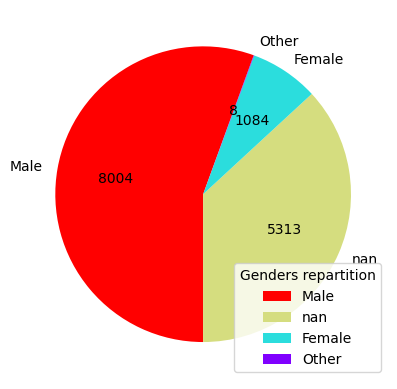

In [10]:
y = df.loc[:,"gender"].value_counts(dropna=False)
mylabels = ["Male", "nan", "Female","Other"]
colors = cm.rainbow_r(np.linspace(0, 1, len(mylabels)))
plt.pie(y, labels = mylabels,startangle = 70, autopct=lambda x: '{:.0f}'.format(x*y.sum()/100),colors=colors)
plt.legend(title = "Genders repartition")
plt.savefig("gender.eps", format="eps")
plt.show() 
